<a href="https://colab.research.google.com/github/Yanmi01/Blockchain-Development-Resources/blob/main/Neural_Network_from_scratch_with_Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import  math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._backward = lambda: None
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)    #this line of code help to convert normal numbers to the format recognizable by the system to make operations possible
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)    #this line of code help to convert normal numbers to the format recognizable by the system to make operations possible
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1      # we used this method of dividion ecause it is easier to differentiate


  def __neg__(self):
    return self * -1


  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


  def __rmul__(self, other): # other * self
    return self * other

  def __radd__(self, other): # other + self
    return self + other


In [3]:
a = Value(3.0)
a+ 1

Value(data=4.0)

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0,  label='w2')

#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

if you run

*   a = Value(3.0)
*   a+3
*   you will get an error message because they are of different format. So, to solve this, " other = other if isinstance(other, Value) else Value(other)" has to be wrapped in the add method and multiply method o prevent such errors.
*   Also, if yoiu do a * 2, an error will be returned. this is because the method indicates a.__mul__(2), so, it doesn't know how to fix 2.__mul__(a)
*   Hence, a new method ___rmul__ is created which checks if the value can be manipoulated by the new input. if true it allows the manipulation
*   List item





In [6]:
2 +a

Value(data=5.0)

In [7]:
a.exp()

Value(data=20.085536923187668)

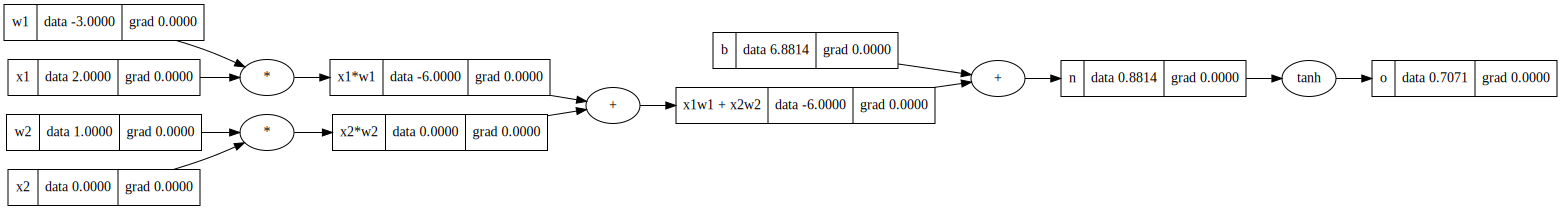

In [8]:
draw_dot(o)

In [9]:
o.backward()

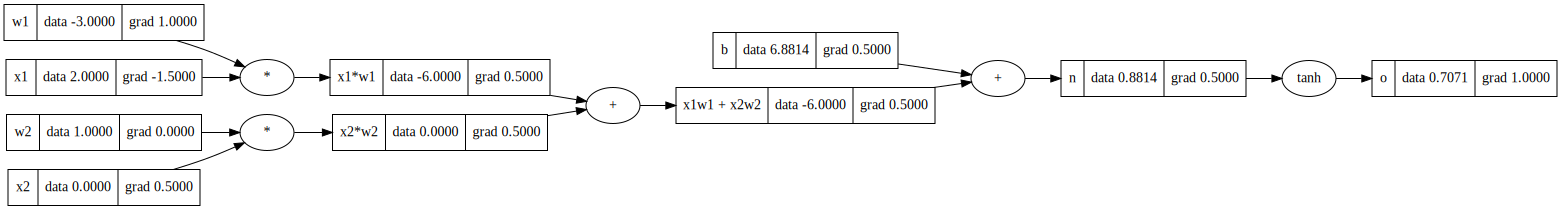

In [10]:
draw_dot(o)

breaking tanh down into an expression

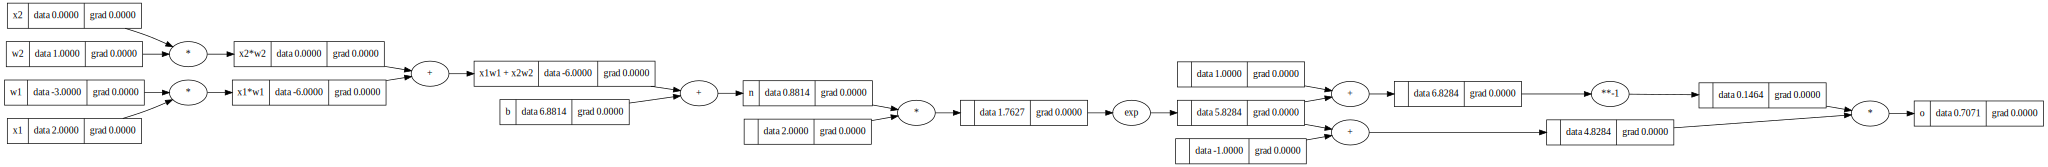

In [11]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0,  label='w2')

#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

#---------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#------------

o.label='o'
#o.backward()
draw_dot(o)

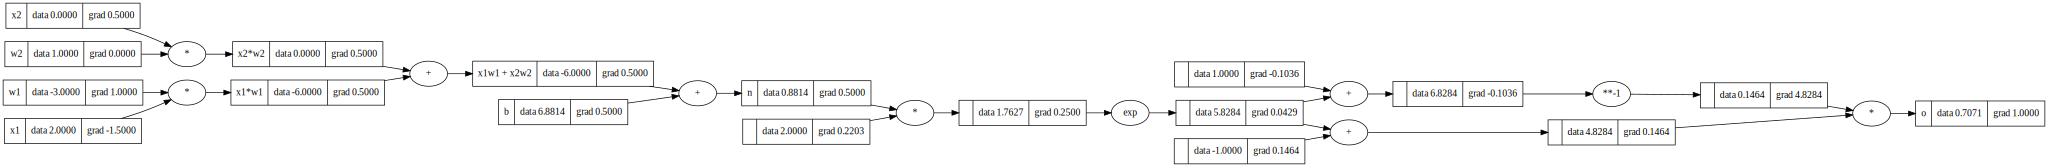

In [12]:
o.backward()
draw_dot(o)

Using pytorch

In [13]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print(o.data)
print(o.data.item()) # check result to see why the .item is necessary
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.7071], dtype=torch.float64)
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


we casted the variables to double because pyorch by default is a float32 variable while python is a float64. so, to ensure theyre having the same precision.

*   Also, because they are root nodes, python assumes they do not require gradient, it needs to be specified
*   List item



# Building Neural Net from Scratch

As we know, Neural Nets are just specific class of mathematical expressions

In [15]:
import random

In [16]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

x = [5.0, 6.0]
n = Neuron(7)
n(x)

Value(data=-0.9999977984744661)

In [17]:
# creating multiple layers
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.7843299119702697),
 Value(data=0.5355894347137174),
 Value(data=-0.9980702364690491)]

the above shows we have 3 independent neurons

In [18]:
# creating multiple layer perceptron
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs   # the statement gives us a cleaner ouput

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts           #instead of taking a sinle nouts, we get a list of nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]    #we get the nouts and iterate them over their consecutive pair of sizes and creating a layer object for them

  def __call__(self, x):
    for layer in self.layers:    # Here we just call them sequentially, typical of an mlp
      x = layer(x)
    return x

# implementing 3 input neuron, 2 hidden layer of 4 neurons each and a single output neuron
x = [2.0, 3.0, -1.0]  # 3D input
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9190738066595144)

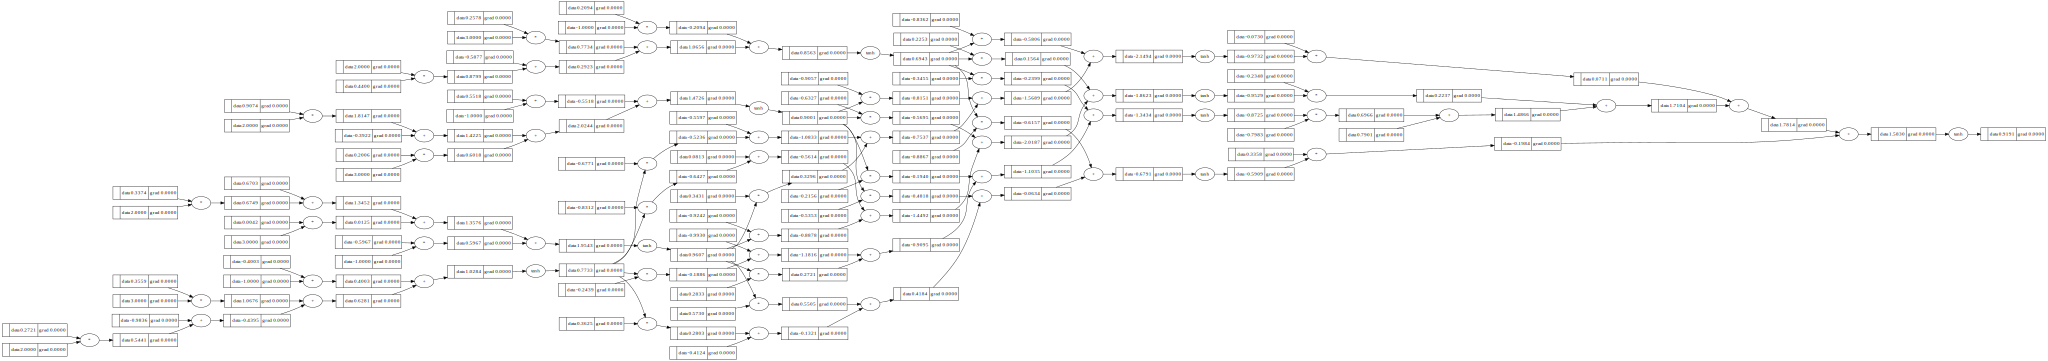

In [19]:
draw_dot(n(x))


In [20]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.9190738066595144),
 Value(data=0.8685274264054936),
 Value(data=0.8186829189459697),
 Value(data=0.9111342674859924)]

seeing that the prediction is very poor, we have to calculate the loss

In [21]:
#implementing mean squared error loss
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]   # we pair the groundtruth with the predictions with the zip iterating the tuples of them
loss

[Value(data=0.00654904876858165),
 Value(data=3.4913947432295376),
 Value(data=3.3076075596658323),
 Value(data=0.007897118415251156)]

In [22]:
#then we add the loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.813448470079202)

In [23]:
#we want to minimize the loss

loss.backward()

In [24]:
n.layers[0].neurons[0].w[0].grad

0.540744653410451

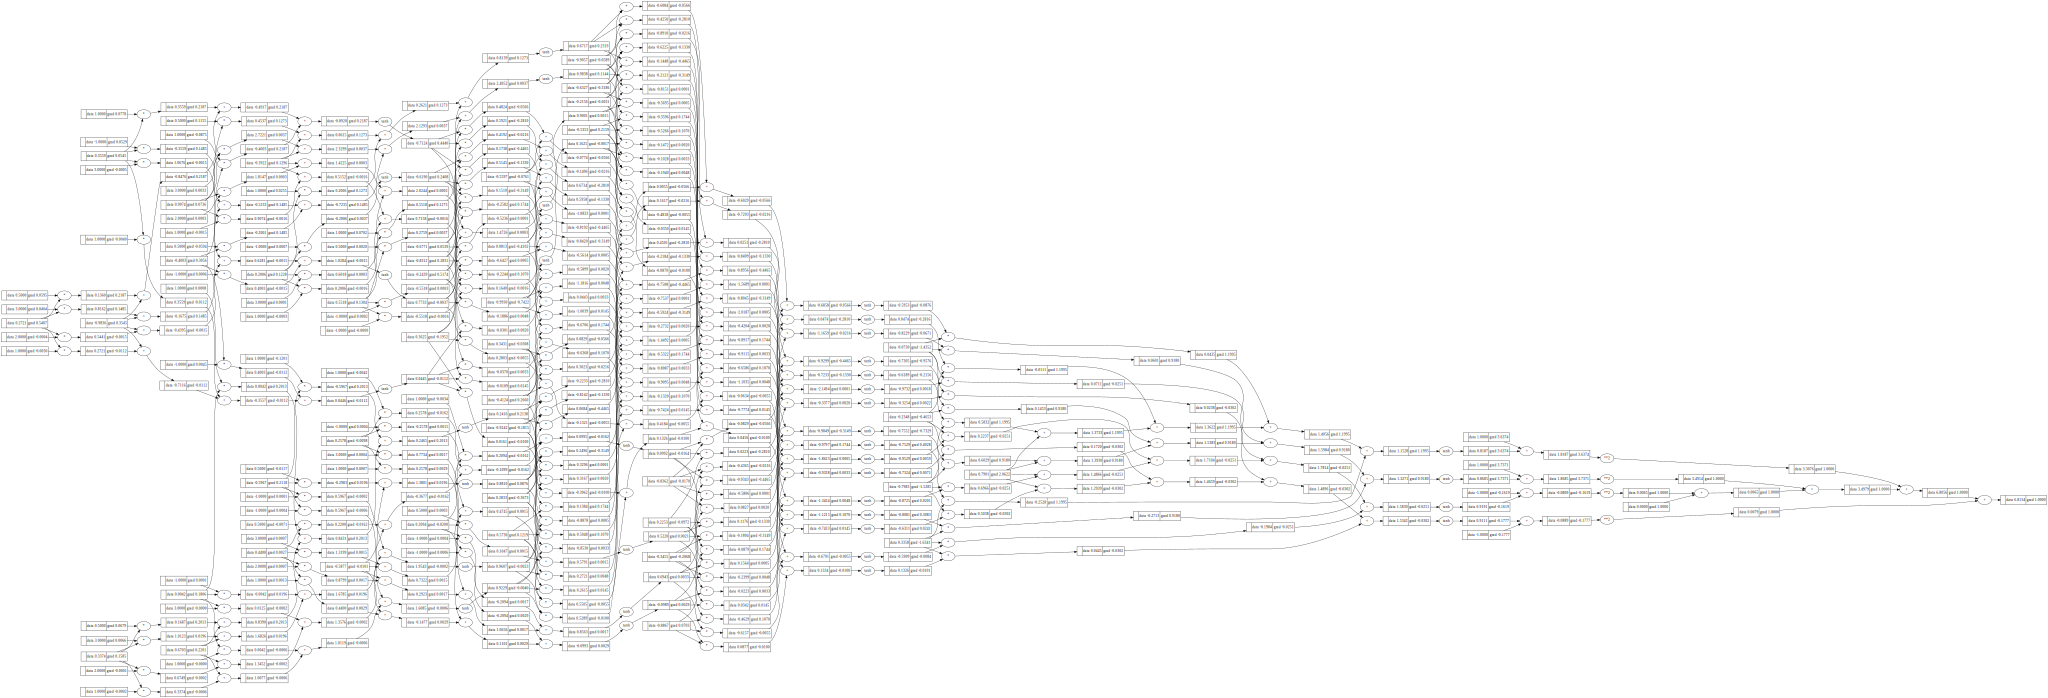

In [25]:
draw_dot(loss)

we'll need to create a parameter method that can be used to track and modify the weights of the neural net

In [26]:
# creating multiple layer perceptron
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]     #returning params as a list

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

    return [p for neuron in self.neurons for p in neuron.parameters()] # using list comprehension

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [27]:
x = [2.0, 3.0, -1.0]  # 3D input
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.24408103114646046)

In [28]:
len(n.parameters())

41

In [29]:
n.parameters()  #lists all the weights & biases in the network

[Value(data=-0.24219916886631898),
 Value(data=-0.0947514357647623),
 Value(data=-0.12500638459303826),
 Value(data=0.16042853096106247),
 Value(data=0.15686145962334264),
 Value(data=-0.32307580452114015),
 Value(data=0.8681790364724853),
 Value(data=-0.1726028042886616),
 Value(data=0.6506180895317004),
 Value(data=-0.8241719734088151),
 Value(data=0.4682105159275052),
 Value(data=0.9912174762479189),
 Value(data=-0.9238189687458276),
 Value(data=0.5560728713556335),
 Value(data=-0.7249941630755345),
 Value(data=-0.950141661484285),
 Value(data=-0.9565737963296912),
 Value(data=-0.08087994545549426),
 Value(data=0.6717923341162577),
 Value(data=0.1542289736702509),
 Value(data=-0.4617662869025623),
 Value(data=0.03162525223323365),
 Value(data=-0.8461189445529234),
 Value(data=0.05447712516534331),
 Value(data=-0.9417978160598559),
 Value(data=-0.9030496826496826),
 Value(data=0.4481654999131972),
 Value(data=0.4424814504176151),
 Value(data=0.6104667301868367),
 Value(data=0.1560870

In [30]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.24408103114646046),
 Value(data=-0.5712368327348624),
 Value(data=-0.5512724148481934),
 Value(data=-0.5263578504405233)]

In [31]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.262700198939259)

In [32]:
loss.backward()

In [33]:
n.layers[0].neurons[0].w[0].grad #gradient on the loss

-0.09490434687437088

In [36]:
n.layers[0].neurons[0].w[0].data

-0.18281865883062914

Implemeting gradient descen

In [37]:
for p in n.parameters():
  p.data += -0.01 * p.grad # this reduces it in the opposite direction of the gradient, reducing the loss

In [38]:
n.layers[0].neurons[0].w[0].data

-0.18279912057747175

As we can see, it became less negative; i.e; more positive

In [39]:
#now let's calculate the loss
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.012961874751629302)

the drastic reduction in the loss means our predictions are much more closer to the target. Doing this repeatedly reduces the loss gradually till it becomes very cloise to the desired output. We can automate this process using a for loop

In [78]:
x = [2.0, 3.0, -1.0]  # 3D input
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4606618431004074)

In [79]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.4606618431004074),
 Value(data=0.5550362956753003),
 Value(data=0.47927685417565175),
 Value(data=0.35006070745734347)]

In [82]:
for k in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.5 * p.grad

  print(k, loss.data)

0 7.999997037895989
1 7.999997037198749
2 7.999997036500968
3 7.999997035802645
4 7.999997035103777
5 7.999997034404366
6 7.99999703370441
7 7.999997033003908
8 7.9999970323028595
9 7.999997031601265
10 7.999997030899123
11 7.999997030196431
12 7.999997029493191
13 7.999997028789401
14 7.999997028085061
15 7.9999970273801715
16 7.999997026674725
17 7.999997025968729
18 7.99999702526218
19 7.999997024555077
20 7.999997023847419
21 7.999997023139204
22 7.999997022430434
23 7.999997021721107
24 7.999997021011222
25 7.999997020300778
26 7.999997019589776
27 7.999997018878215
28 7.9999970181660895
29 7.999997017453406
30 7.99999701674016
31 7.9999970160263505
32 7.99999701531198
33 7.9999970145970405
34 7.999997013881538
35 7.999997013165471
36 7.999997012448835
37 7.999997011731635
38 7.999997011013864
39 7.999997010295526
40 7.999997009576619
41 7.9999970088571395
42 7.99999700813709
43 7.999997007416469
44 7.999997006695274
45 7.999997005973508
46 7.999997005251168
47 7.999997004528251
4

In [83]:
ypred

[Value(data=-0.9999998738185272),
 Value(data=-0.9999999103416756),
 Value(data=-0.999999909031682),
 Value(data=-0.999999376951541)]